In [ ]:
## EEG signal classification into wake and drowsy using CNN network

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/intern_eyecare/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it wi

In [2]:
file_location=r'/home/intern_eyecare/Desktop/EEG/raw_EEG_3_pat' #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg'
os.chdir(r'/home/intern_eyecare/Desktop/EEG/raw_EEG_3_pat') #C:\Users\BOL1KOR\Desktop\BCI Project\Pickle_Files\Pickle_files_eeg')


In [3]:
dfull = pickle.load(open('raw_EEG_3_patients.pkl', 'rb'))  #raw_EEG_all_patients.pkl

In [4]:
dfull.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,pID,day,epoch,class_label
0,5.016850,-2.578755,1.359707,-2.391209,-5.204396,-7.454945,-8.298901,-6.892308,-3.704029,-0.984615,...,26.959707,33.148718,28.741392,41.588278,28.084982,43.276190,400,1,s1e1,wake
1,11.299634,18.145055,18.801465,17.301099,13.831502,6.610989,7.454945,7.454945,7.267399,8.486447,...,8.486447,13.175092,16.926007,17.394872,9.517949,13.362637,400,1,s1e2,wake
2,13.362637,10.736996,6.329670,6.892308,4.454212,18.238828,12.143590,13.925275,8.486447,7.548718,...,15.706960,3.610256,15.238095,2.953846,3.891575,-0.046886,400,1,s1e3,wake


In [5]:
### Convert from 3-class to 2-class ####
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

In [6]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'
#dfull[['class_label']] = dfull[['class_label']].astype('category')   # ,'class2'

In [7]:
dfull.groupby('class_label').size()

class_label
sleep_stage_1      596
sleep_stage_2     2792
wake             11340
dtype: int64

In [8]:
## drop column '2999' with NAN values instead of dropping the rows (which will reduce data)
dfull = dfull.drop([2999],1)
dfull.head(1)

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,pID,day,epoch,class_label,class2
0,5.01685,-2.578755,1.359707,-2.391209,-5.204396,-7.454945,-8.298901,-6.892308,-3.704029,-0.984615,...,26.959707,33.148718,28.741392,41.588278,28.084982,400,1,s1e1,wake,0


In [ ]:
### 3 patient data

In [9]:
#### segregate data into train:test set by pat id, then balance the data
Test = dfull[ (dfull.pID == '402') & (dfull.day == '2') ]
Train = dfull[~( (dfull.pID == '402') & (dfull.day == '2') )]

In [10]:
print(Train.shape)
print(Test.shape)

(12271, 3004)
(2457, 3004)


In [11]:
X_train = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
y_train = Train['class2'].reset_index()
y_test = Test['class2'].reset_index()

X_train = X_train.drop(['index'], 1)
X_test = X_test.drop(['index'],1)
y_train = y_train.drop(['index'],1)
y_test = y_test.drop(['index'],1)

print(X_train.head(1))
#print(X_test.head(1))
print('')
print(y_train.head(1))
#print(y_test.head(1))

      0         1         2         3         4         5         6     \
0  5.01685 -2.578755  1.359707 -2.391209 -5.204396 -7.454945 -8.298901   

       7         8         9       ...           2989       2990       2991  \
0 -6.892308 -3.704029 -0.984615    ...      45.057875  47.027106  37.649817   

        2992       2993       2994       2995       2996       2997       2998  
0  35.211722  33.898901  26.959707  33.148718  28.741392  41.588278  28.084982  

[1 rows x 2999 columns]

   class2
0       0


In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# standardscaler: suitable for normally distributed data
# minMaxScaler: (x-min)/(max - min)

## normalize the data  : can also use other scalers like StandardScaler()
scaler = StandardScaler()  #MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled.shape

In [13]:
## re-shaping tha data for input to conv net
# https://stackoverflow.com/questions/43235531/convolutional-neural-network-conv1d-input-shape
nrows, ncols = X_train_scaled.shape
X_train_array =  X_train_scaled.reshape(nrows, ncols, 1)
print(X_train_array)

[[[ 0.17974824]
  [-0.10464995]
  [ 0.04938876]
  ...
  [ 1.06197569]
  [ 1.55018501]
  [ 1.04462293]]

 [[ 0.41734971]
  [ 0.67328311]
  [ 0.70750367]
  ...
  [ 0.61108146]
  [ 0.63323868]
  [ 0.33625525]]

 [[ 0.49536811]
  [ 0.39519844]
  [ 0.23691613]
  ...
  [ 0.546668  ]
  [ 0.08591412]
  [ 0.12159838]]

 ...

 [[-0.22466741]
  [-0.23480963]
  [-0.17083979]
  ...
  [ 0.42133573]
  [ 0.40602902]
  [ 0.23901681]]

 [[ 0.65154342]
  [ 0.79777769]
  [ 0.70338492]
  ...
  [-0.15637251]
  [-0.15723326]
  [-0.14837177]]

 [[-0.04314166]
  [-0.08927719]
  [-0.05938485]
  ...
  [-1.46326125]
  [-1.53215298]
  [-1.53592722]]]


In [ ]:
#### model building ####

In [14]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-10 09:14:51'

In [15]:
# define model: 1 conv layer, 1 fully-connected layer, 1 output layer
model = Sequential()  ## to initialize NN

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ncols, 1))) 
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # this is the output layer for binary classification
print(model.summary())

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2997, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1498, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 95872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                4793650   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,793,957
Trainable params: 4,793,957
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train_array, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

Train on 11043 samples, validate on 1228 samples
Epoch 1/100
11043/11043 [==============================] - 8s 767us/step - loss: 0.3613 - acc: 0.8338 - val_loss: 0.5182 - val_acc: 0.8640
Epoch 2/100
11043/11043 [==============================] - 7s 599us/step - loss: 0.2083 - acc: 0.9338 - val_loss: 0.4695 - val_acc: 0.7736
Epoch 3/100
11043/11043 [==============================] - 7s 619us/step - loss: 0.1615 - acc: 0.9659 - val_loss: 0.5177 - val_acc: 0.7476
Epoch 4/100
11043/11043 [==============================] - 7s 619us/step - loss: 0.1370 - acc: 0.9756 - val_loss: 0.4790 - val_acc: 0.8094
Epoch 5/100
11043/11043 [==============================] - 7s 624us/step - loss: 0.1173 - acc: 0.9812 - val_loss: 0.4801 - val_acc: 0.8111
Epoch 6/100
11043/11043 [==============================] - 7s 604us/step - loss: 0.1049 - acc: 0.9841 - val_loss: 0.3737 - val_acc: 0.8974
Epoch 7/100
11043/11043 [==============================] - 7s 602us/step - loss: 0.0939 - acc: 0.9857 - val_loss: 0.3

In [17]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2019-01-10 09:26:04'

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


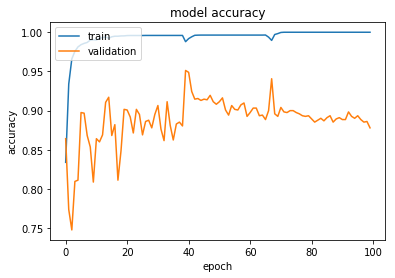

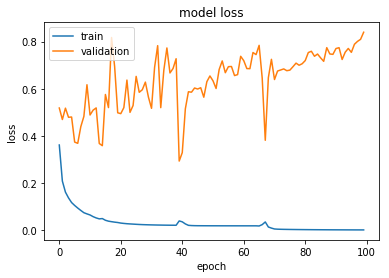

In [18]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
## predict on test data - check metrics
#y_pred = model_svc.predict(X_test_scaled)

nrows2, ncols2 = X_test_scaled.shape
X_test_array =  X_test_scaled.reshape(nrows2, ncols2, 1)
y_pred = model.predict(X_test_array)

In [20]:
print(y_test.head(2))
print('')
print(y_test.tail(3))

   class2
0       0
1       0

      class2
2454       1
2455       1
2456       1


In [21]:
y_pred

array([[1.9440890e-14],
       [7.7235641e-25],
       [2.0698925e-31],
       ...,
       [9.9688220e-01],
       [9.9688220e-01],
       [9.8540175e-01]], dtype=float32)

In [25]:
# convert array to dataframe

y_pred2 = pd.DataFrame(y_pred)
print(y_pred2.head(2))
print('')
print(y_pred2.tail(2))

              0
0  1.944089e-14
1  7.723564e-25

             0
2455  0.996882
2456  0.985402


In [27]:
y_pred3 = round(y_pred2)
y_pred3
print(y_pred3.head(2))
print('')
print(y_pred3.tail(2))

     0
0  0.0
1  0.0

        0
2455  1.0
2456  1.0


In [28]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
## Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

class_names = [0,1] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

print(confusion_matrix(y_test, y_pred3))

[[1871    0]
 [ 194  392]]


In [32]:
print(classification_report(y_test, y_pred3, target_names=class_names))

TypeError: object of type 'int' has no len()

In [ ]:
## steps to plot train & validation accuracy & loss

https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

history = model.fit(x_test, y_test, nb_epoch=10, validation_split=0.2, shuffle=True)

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()